In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../data/student-por.csv')

In [3]:
Y = data[['G1', 'G2', 'G3']].sum(axis=1)
X = data.drop(['G1', 'G2', 'G3'], axis=1)
Y = Y.apply(lambda x: 1 if x > 36 else 0)

In [4]:
random_state = 9527

pca_1d = PCA(5, random_state=random_state)
L_sk = pca_1d.fit_transform(X)
print(pca_1d.explained_variance_ratio_)
print('L_sk.shape:', L_sk.shape)
print('L_sk:', L_sk[:, :4])


[0.52424711 0.07050346 0.06545911 0.05062572 0.03483436]
L_sk.shape: (649, 5)
L_sk: [[ 0.30496353 -0.27002464 -0.83606091  0.36187049]
 [-1.77714874  2.67705741 -1.10328362 -0.5268237 ]
 [ 2.26409563  1.98388544 -0.71914165  0.12464743]
 ...
 [ 2.26323333  2.08418604 -1.77640727 -2.65372224]
 [ 2.57562727  0.23117274  2.21383997  2.34036755]
 [ 0.46668598 -0.14984225  2.01225714 -1.38267225]]


In [5]:
# Define the logistic regression model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),  # Input layer for 30 features
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
log_data = []
best_report= None
curr_best_model = None
best_f1 = 0
for i in range(1, 99):
    X_train, X_test, y_train, y_test = train_test_split(L_sk, Y, test_size=i / 100, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

    y_pred = model.predict(X_test_scaled)
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate additional metrics if needed (e.g., precision, recall)

    if f1 > best_f1 and 80 > i > 20 :
        best_f1 = f1
        curr_best_model = model
        best_report = classification_report(y_test, y_pred)
    log_data.append({'Iteration': i, 'F1 Score': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})



20/20 [==============================] - 0s 734us/step


In [6]:
log_df = pd.DataFrame(log_data)
print(best_report)
curr_time = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')
log_df.to_csv(f"../reports/pca_then_lr_{curr_time}.csv", index=False)

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       136
           1       0.67      0.64      0.65       111

    accuracy                           0.70       247
   macro avg       0.69      0.69      0.69       247
weighted avg       0.70      0.70      0.70       247


In [7]:
curr_best_model.summary()
best_f1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


0.6543778801843319

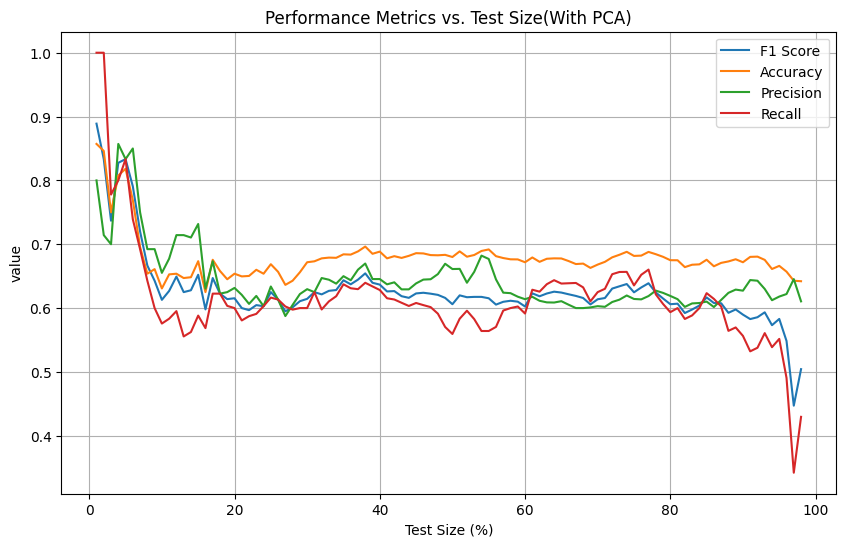

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(log_df['Iteration'], log_df['F1 Score'], label='F1 Score')
plt.plot(log_df['Iteration'], log_df['Accuracy'], label='Accuracy')
plt.plot(log_df['Iteration'], log_df['Precision'], label='Precision')
plt.plot(log_df['Iteration'], log_df['Recall'], label='Recall')

plt.xlabel('Test Size (%)')
plt.ylabel('value')
plt.title('Performance Metrics vs. Test Size(With PCA)')
plt.legend()
plt.grid(True)
plt.show()